---
title: Sparse Kernelized Logistic Regression
author: Evan Flaks
date: '2025-04-16'
image: "kernel.jpeg"
description: "Implementing Kernelized Logistic Regression and Performing Various Data Experiments"
format: html
---

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np


%load_ext autoreload
%autoreload 2
from kernel import KernelLogisticRegression

# Abstract

This project explores the implementation and behavior of L1-regularized kernelized logistic regression ([kernel.py](https://github.com/evanflaks/evanflaks.github.io/blob/main/posts/kernel/logistic.py)), focusing on how both the regularization strength ($\lambda$) and the RBF kernel parameter ($\gamma$) affect model complexity, sparsity, and generalization. The algorithm was built from scratch using PyTorch and tested on synthetic datasets with nonlinear structures to evaluate its ability to separate data that is may not be linearly separable. Experiments were conducted to visualize the number of non-zero weights, decision boundaries, and performance metrics such as ROC curves. Special attention was given to how the model handles underfitting and overfitting across different hyperparameter configurations. This approach enabled an in-depth investigation into how kernel methods, paired with L1 regularization, can effectively balance flexibility and generalization in complex classification tasks.

# Implementation

My implementation of Kernelized Logistic Regression is in this [kernel.py](https://github.com/evanflaks/evanflaks.github.io/blob/main/posts/kernel/logistic.py) script.

A ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍sparse ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍kernel ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍machine ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍a ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍kernelized linear model ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍which ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍has ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍been ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍modified ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍to ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍ensure ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍that ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍many ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍entries ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍weight ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍vector **a**
 ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍are ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍equal ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍to ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍exactly ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍zero. ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍

In ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍sparse ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍kernelized ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍logistic ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍regression, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍score ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍a ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍feature ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍vector ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍
 ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍**x** is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍computed ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍as

 \begin{aligned}
    s = \sum_{i = 1}^n a_i k(\mathbf{x}, \mathbf{x}_{t,i})\;
\end{aligned}

where ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍$\mathbf{x}_{t,i}$
 ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍$i$th ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍entry ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍training ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍data ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍and ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍$k$
 ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍a ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍positive-definite ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍kernel.

 The ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍loss ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍function ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍for ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍sparse ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍kernel ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍logistic ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍regression ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍on ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍data ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍set $‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍\mathbf{X} \in \mathbb{R}^{m\times p}$
 ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍is

\begin{aligned}
    L(\mathbf{a}) = -\frac{1}{m} \sum_{j = 1}^m \left[y_j\log \sigma(s_j) + (1-y_j)\log (1-\sigma(s_j)) \right] + \lambda \lVert \mathbf{a} \rVert_1\;.
\end{aligned}

Here, $\lambda$ is a regularization strenght and $\lVert \mathbf{a} \rVert_1$ is the $\ell_1$ norm of **a**. This ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍specific ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍choice ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍norm ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍what ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍will ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍make ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍our ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍model ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍sparse.

My implementation of KernelLogisticRegression performs L1-regularized logistic regression in the dual form using a kernel function to enable nonlinear decision boundaries. Instead of learning weights for input features, the model learns a set of dual coefficients (a) corresponding to each training point. These coefficients are trained using a logistic loss with L1 regularization, which encourages sparsity—meaning only a few training points (support vectors) will have non-zero influence. The fit method computes the kernel matrix over the training data and uses gradient descent with a proximal (soft-thresholding) step to update the weights. The score method computes the model’s raw outputs for new data based on kernel similarity to the training set, while the predict method converts these scores into binary class predictions using a sigmoid activation and a 0.5 threshold.

# Experiments

Let's generate ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍a ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍simple ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍data ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍set ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍with ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍a ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍roughly ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍linear ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍separating ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍boundary using the code below.



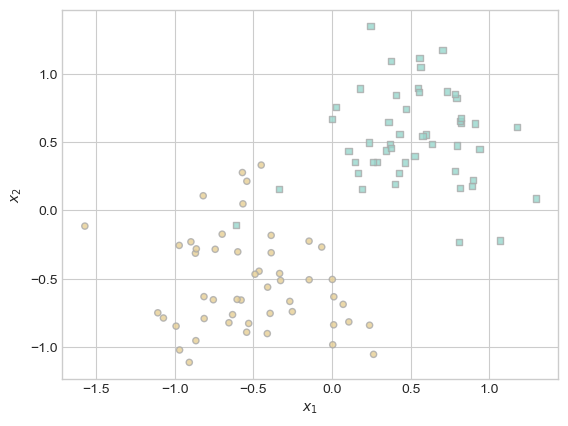

In [2]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    # X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    X = X - X.mean(dim = 0, keepdim = True)
    return X, y


def plot_classification_data(X, y, ax):
    assert X.shape[1] == 2, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -1, vmax = 2, alpha = 0.8, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = classification_data(n_points = 100, noise = 0.4)
plot_classification_data(X, y, ax)

The <code>rbf_kernel</code> function below computes the Radial Basis Function kernel — a popular way to measure similarity between data points. It takes two sets of vectors, $X_1$ and $X_2$, and returns a matrix where each entry represents how similar a point in $X_1$ is to a point in $X_2$. It does this by computing the squared Euclidean distances between the points (via torch.cdist), scaling those distances by gamma, and applying the exponential function. The result is a kernel matrix where closer points have values near 1 and more distant points have values near 0.

In [3]:
def rbf_kernel(X_1, X_2, gamma):
    return torch.exp(-gamma*torch.cdist(X_1, X_2)**2)

Below, I have ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍code that specifies  ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍500,000 ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍epochs ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍gradient ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍descent ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍with ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍a ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍learning ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍rate ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍
$10^{-4}$. ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍The ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍parameter <code>gamma</code>  ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍a ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍keyword ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍passed ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍to ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍<code>rbf_kernel</code>  ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍which ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍controls ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍bandwidth as it is a ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍hyperparameter ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍that ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍can ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍be ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍tuned ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍in ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍cross-validation.

In [7]:
KR = KernelLogisticRegression(rbf_kernel, lam = 0.1, gamma = 1)
KR.fit(X, y, epochs = 500000, lr = 0.0001)

Inspecting ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍weight ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍vector <code>KR.a</code> ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍shows ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍that ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍most ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍entries ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍are ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍very ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍close ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍to ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍zero.

In [8]:
(1.0*(KR.a > 0.001)).mean()

tensor(0.1100)

The ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍code ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍block ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍below ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍plots ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍scores ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍along ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍with ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍training ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍data, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍and ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍will ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍highlight ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍pieces ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍training ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍data ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍which ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍have ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍weights ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍distinguishable ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍from ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍0.

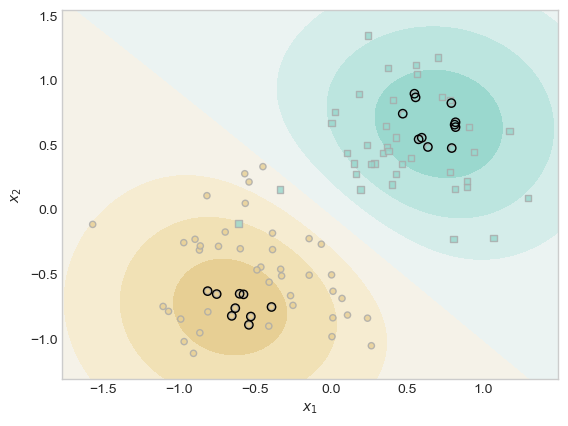

In [9]:
ix = torch.abs(KR.a) > 0.001

x1 = torch.linspace(X[:,0].min() - 0.2, X[:,0].max() + 0.2, 101)
x2 = torch.linspace(X[:,1].min() - 0.2, X[:,1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim = 1)

preds = KR.score(X_)
preds = 1.0*torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG", 
vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
)
plot_classification_data(X, y, ax)
plt.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")
# ax.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")

As we can see, many of the data points do not have large weight entries, indicated by the few number of black circles. This means that only a small number of training points have meaningful influence on the decision boundary, which can make for a simpler model that is good at generalizing. Intuitively, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍this ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍reflects ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍idea ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍that, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍to ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍check ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍whether ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍a ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍given ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍point ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍a ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍brown ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍circle, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍it ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍might ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍be ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍sufficient ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍to ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍check ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍only ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍whether ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍that ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍point ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍sufficiently ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍close ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍to ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍“center” ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍brown ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍region ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍and ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍sufficiently ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍far ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍from ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍“center” ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍blue ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍region.

## Basic Experiment 1: Large $\lambda$

For our first experiment, we want to show that when $\lambda$ is very large, there may be only one point in the trianing data with a weight distinguishable from zero. 

The code below generates a synthetic classification dataset and trains a kernelized logistic regression model using different values of the regularization parameter $\lambda$ (lambda). For each lambda value, it fits the model and counts how many weights are significantly different from zero, indicating how many training points are used as support vectors. The results are plotted on a graph that shows how increasing $\lambda$ (on a log scale) reduces the number of non-zero weights, demonstrating the sparsity-inducing effect of stronger regularization.

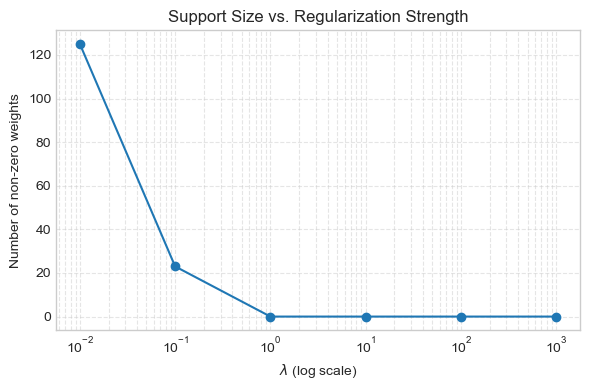

In [10]:
import torch
from matplotlib import pyplot as plt

X, y = classification_data(n_points=300, noise=0.3)
gam = 1.0
lam_vals = [0.01, 0.1, 1, 10, 100, 1000]
nz_counts = []
threshold = 1e-3

for lam in lam_vals:
    model = KernelLogisticRegression(rbf_kernel, lam=lam, gamma=gam)
    model.fit(X, y)
    count_nz = (model.a.abs() > threshold).sum().item()
    nz_counts.append(count_nz)

plt.figure(figsize=(6,4))
plt.plot(lam_vals, nz_counts, marker='o')
plt.xscale('log')
plt.xlabel(r"$\lambda$ (log scale)")
plt.ylabel("Number of non-zero weights")
plt.title("Support Size vs. Regularization Strength")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

As we can see from the plot above, after $\lambda = 1$, the number of non-zero weight vectors becomes indistinguishable from zero. 

Now we want to show that there can be a lambda value where our data set has only *one* weight vector disinguishable from zero. Looking at the plot above, this happens somewhere in between the lambda values of $0.1$ and $1$. So, the code below performs a fine-grained search over 500 $\lambda$ values between $0.1$ and $1.0$ to find a model that results in exactly one non-zero weight in the dual parameter vector a of a kernelized logistic regression model. For each lambda, it trains the model on a dataset X, y and checks how many of the learned weights are above a small threshold, indicating which training points act as support vectors. When it finds a lambda that results in exactly one such support vector, it prints the lambda and the index of that point.

In [11]:
# Narrow sweep between 0.1 and 1
lam_range_zoom = np.linspace(0.1, 1.0, 500)  # 500 λ values between 0.1 and 1
threshold = 1e-3
gamma = 1.0

found = False

for lam in lam_range_zoom:
    model = KernelLogisticRegression(kernel_fn=rbf_kernel, lam=lam, gamma=gamma)
    model.fit(X, y)
    support_ix = torch.where(model.a.abs() > threshold)[0]

    if len(support_ix) == 1:
        print(f"✅ Found λ = {lam:.5f} with exactly one non-zero weight at index {support_ix.item()}")
        a_star = model.a.clone()
        support_idx = support_ix.item()
        found = True
        break

if not found:
    print("❌ No λ found with exactly one non-zero weight in the range 0.1–1.0.")


✅ Found λ = 0.18116 with exactly one non-zero weight at index 191


As we can see, for our particular synthetic data set, at the lambda value of $\lambda = 0.18116$, there is exactly one non-zero weight vector.

The code below visualizes the dataset along with its support vectors after training a kernelized logistic regression model. The <code>plot_data_and_supports</code> function takes the data points X, their labels y, and the indices of non-zero weights (support vectors), and plots all points with color-coded labels while highlighting the support vectors with large green-outlined markers. The main code block then retrains the model using a specific lambda value ($\lambda = 0.18116$), which we found to produce exactly one non-zero weight. It identifies the support vector, asserts that there is exactly one, and uses the plotting function to display the data and circle the lone support vector.

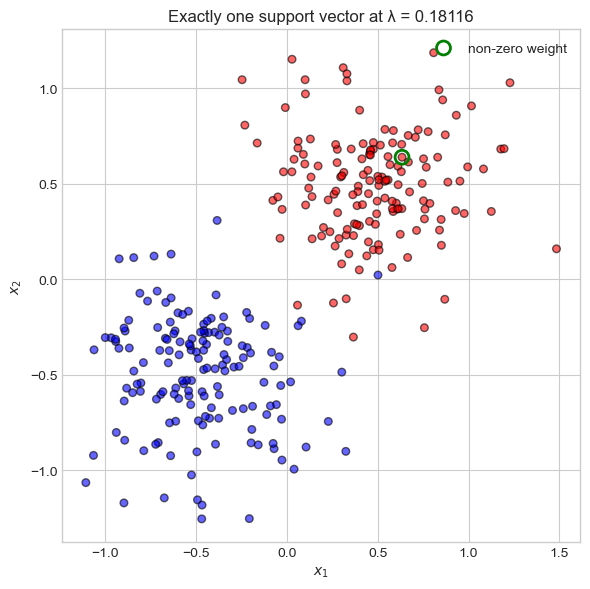

In [12]:
def plot_data_and_supports(X, y, support_ix, ax):
    # Plot all points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap="bwr", edgecolors="k", s=30, alpha=0.6)
    
    # Highlight support vectors
    ax.scatter(X[support_ix, 0], X[support_ix, 1],
               facecolors='none', edgecolors='g', linewidths=2, s=100,
               label="non-zero weight")
    
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_title("Data and Support Vectors")

    if len(support_ix) > 0:
        ax.legend(loc="upper right")


lam = 0.18116
gamma = 1.0
threshold = 1e-3

# Re-train model at exact λ
model = KernelLogisticRegression(kernel_fn=rbf_kernel, lam=lam, gamma=gamma)
model.fit(X, y)

# Confirm support vector again
support_ix = torch.where(model.a.abs() > threshold)[0]
assert len(support_ix) == 1

fig, ax = plt.subplots(figsize=(6, 6))
plot_data_and_supports(X, y, support_ix, ax)
plt.title(f"Exactly one support vector at λ = {lam:.5f}")
plt.tight_layout()
plt.show()


This visualization clearly shows how strong regularization can result in the model relying on just one training point for decision-making.

## Basic Experiment 2: Adjusting $\gamma$

For our second experiment, we want to show that changing ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍$\gamma$
 ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍can ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍result ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍in ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍wigglier ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍decision ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍boundaries.

 The code below defines and runs an experiment to visualize how different values of the kernel hyperparameter $\gamma$ (gamma) affect the decision boundaries learned by a kernelized logistic regression model. The function <code>run_gamma_experiment_contours</code> takes in training data and a list of gamma values, trains a separate model for each gamma, and evaluates the model’s decision scores on a grid of points spanning the input space. It then plots the resulting decision boundary contours using filled color plots and overlays the original training data.

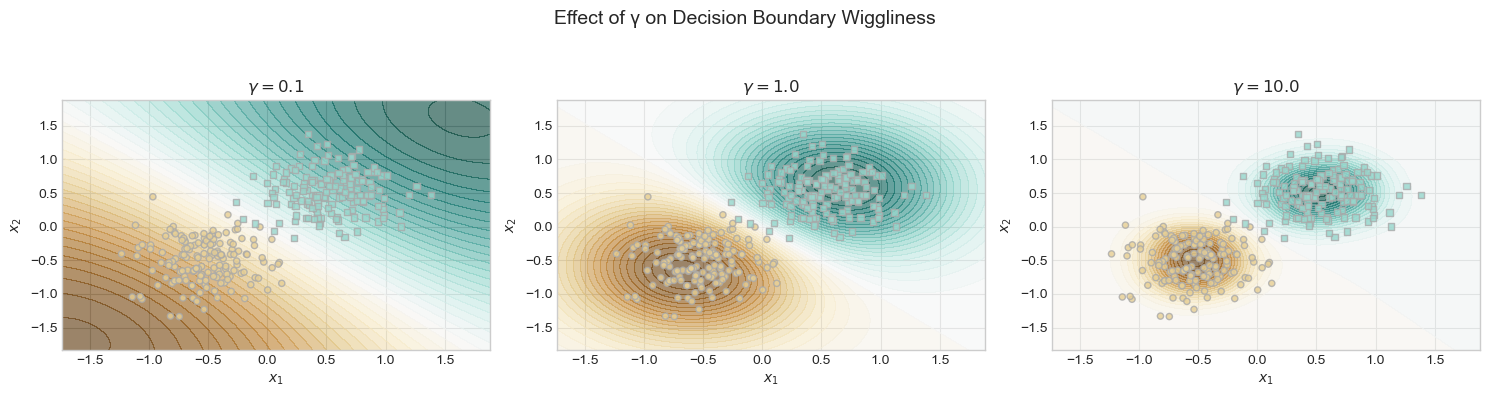

In [65]:
def run_gamma_experiment_contours(X, y, gammas, lam=0.01, lr=1e-4, epochs=100000):
    """
    Train models with different gamma and plot decision boundaries.
    """
    fig, axes = plt.subplots(1, len(gammas), figsize=(5*len(gammas), 4))
    x1 = torch.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 200)
    x2 = torch.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 200)
    X1, X2 = torch.meshgrid(x1, x2, indexing='ij')      # 
    grid = torch.stack([X1.ravel(), X2.ravel()], dim=1)

    for ax, gamma in zip(axes, gammas):
        # Train model
        KR = KernelLogisticRegression(kernel_fn=rbf_kernel, lam=lam, gamma=gamma)
        KR.fit(X, y, lr=lr, epochs=epochs)

        # Score grid & reshape
        scores = KR.score(grid).detach().numpy().reshape(X1.shape)
        # Plot contour
        cf = ax.contourf(X1.numpy(), X2.numpy(), scores,
                         levels=50, cmap="BrBG", alpha=0.6)
        # Overlay data
        plot_classification_data(X, y, ax)
        ax.set_title(fr"$\gamma = {gamma}$")

    fig.suptitle("Effect of γ on Decision Boundary Wiggliness", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.93])
    plt.show()

# -- Running the experiment --
X, y = classification_data(n_points=300, noise=0.3)
gammas = [0.1, 1.0, 10.0]   # from smooth to very “wiggly”
run_gamma_experiment_contours(X, y, gammas)

As we can see, the plot on the left with the lowest $\gamma$ value produces very smooth and broad decision boundaries, indicating that the model is generalizing the decision surface across larger distances in the input space. With a moderate gamma ($\gamma = 1.0$), the boundary becomes more responsive to the data structure, striking a reasonable balance between fitting the data and maintaining generalization. However, with a high gamma ($\gamma = 10.0$), the boundary becomes extremely wiggly and tightly hugs the training points, a classic sign of overfitting, where the model captures noise and minor variations in the training set instead of learning a general rule.

## Basic Experiment 3: Non-Linear Data

For this experiment, we want to show that when ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍data ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍has ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍a ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍nonlinear ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍pattern, ‍‍‍‍‍‍‍‍‍‍‍ ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍kernel ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍methods ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍with ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍appropriate ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍parameters ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍can ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍find ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍this ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍pattern ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍effectively.

Below, I have generated and visualizes a synthetic dataset known as the "moons" dataset. Using make_moons from sklearn.datasets, it creates 300 data points shaped like two interleaving half-moons, with added noise to make the classification task more realistic.

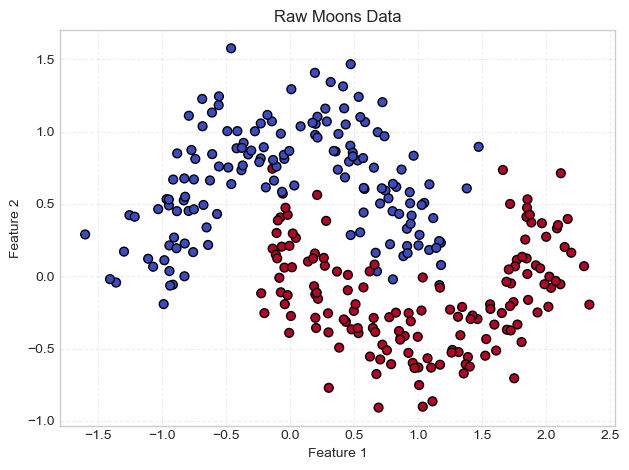

In [13]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# Generate moon data
X_np, y_np = make_moons(n_samples=300, noise=0.2)
X = torch.tensor(X_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.float32)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolor="k", s=40)
plt.title("Raw Moons Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


Now let's train our model and test its accuracy.

In [14]:
# Train model
model = KernelLogisticRegression(kernel_fn=rbf_kernel, lam=0.01, gamma=10)
model.fit(X, y, lr=0.1, epochs=2000)

# Accuracy
y_hat = model.predict(X)
acc = (y_hat == y).float().mean().item()
print(f"Training Accuracy: {acc:.3f}")

Training Accuracy: 0.973


With 97.3% accuracy on the training data, it is clear that our kernelized logistic regression can identify this pattern well. 

To visualize this, I have created a function that shows the decision surface of the trained kernelized logistic regression model on our moons dataset. The function <code>visualize_kernel_model_on_moons</code> creates a dense grid of points spanning the input space and uses the model to compute the predicted class probabilities for each grid point. It then displays a contour plot of the predicted probabilities using color shading to represent the likelihood of class 1, allowing a clear view of the model’s decision boundary.

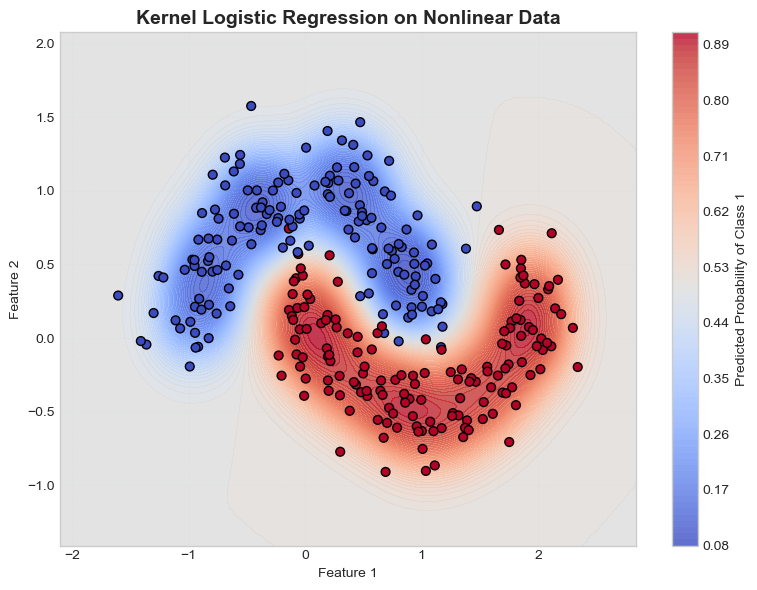

In [15]:
import matplotlib.pyplot as plt

def visualize_kernel_model_on_moons(model, X, y, title="Kernel Logistic Regression on Nonlinear Data"):
    # Create a grid for predictions
    x1 = torch.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, 300)
    x2 = torch.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, 300)
    X1, X2 = torch.meshgrid(x1, x2, indexing="ij")
    grid = torch.stack([X1.ravel(), X2.ravel()], dim=1)

    # Predict probabilities
    probs = torch.sigmoid(model.score(grid)).reshape(X1.shape)

    # Begin plotting
    plt.figure(figsize=(8, 6))
    contour = plt.contourf(X1, X2, probs, levels=100, cmap="coolwarm", alpha=0.8)
    plt.colorbar(contour, label="Predicted Probability of Class 1")

    # Plot training data
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolor="k", s=40)
    plt.title(title, fontsize=14, fontweight="bold")

    # Highlight nonlinear separability
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

visualize_kernel_model_on_moons(model, X, y)

As we can see, the prediction regions are very accurate and closely represent the data set, indicating that kernelized logistic regression can very accurately identify non-linear patterns.

## Demonstrating Overfitting

For this experiment, we want to show ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍an ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍example ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍in ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍which ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍wrong ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍choice ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍$\gamma$
 ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍can ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍result ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍in ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍a ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍badly ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍overfit ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍model, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍as ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍measured ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍by ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍gap ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍between ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍training ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍and ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍testing ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍performance. 

The <code>get_circle_data</code> below function creates a two-dimensional dataset with two concentric circles and adds noise to make the classification task more challenging. Two separate datasets are created using this function: one for training and one for testing, both with the same number of samples and noise level.

In [83]:
from sklearn.datasets import make_circles
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate circular data (nonlinear, good for kernel methods)
def get_circle_data(n_samples=300, noise=0.1):
    X_np, y_np = make_circles(n_samples=n_samples, noise=noise, factor=0.5)
    X = torch.tensor(X_np, dtype=torch.float32)
    y = torch.tensor(y_np, dtype=torch.float32)
    return X, y

# Generate training and test sets using same function
X_train, y_train = get_circle_data(n_samples=300, noise=0.4)
X_test, y_test = get_circle_data(n_samples=300, noise=0.4)

Now we train a kernelized logistic regression model across different values of the hyperparameter $\gamma$ (gamma), ranging from 1 to 1000. A small regularization parameter ($\lambda = 0.001$) and a large number of training epochs (10,000) are used to allow the model to closely fit the training data. For each gamma value, a model is initialized and trained on the training dataset (X_train, y_train) using a learning rate of 0.01. The trained models are stored in a dictionary called models, keyed by their corresponding gamma values.

In [84]:
# Define your KernelLogisticRegression model and rbf_kernel beforehand

gammas = [1, 10, 100, 1000]   # 50.0 should overfit
lam = 0.001
epochs = 10000
models = {}

for gamma in gammas:
    model = KernelLogisticRegression(kernel_fn=rbf_kernel, lam=lam, gamma=gamma)
    model.fit(X_train, y_train, lr=1e-2, epochs=epochs)
    models[gamma] = model


The function below calculates the predicted probabilities for each model on both the training and testing data.

In [85]:
def get_probs(model, X):
    scores = model.score(X)
    return torch.sigmoid(scores).detach().numpy()

probs_train = {g: get_probs(m, X_train) for g, m in models.items()}
probs_test = {g: get_probs(m, X_test) for g, m in models.items()}


Now let's visualize the decision boundaries of of the models for different gamma values on both the training and testing datasets. The <code>plot_decision_boundary</code> function creates a grid of points across the input space, uses the model to predict class probabilities at each point, and then plots contour lines showing the decision boundary. It also overlays the actual data points colored by class label. The code loops through each trained model (based on its gamma value) and plots its decision boundary on the training data and the test data side by side.

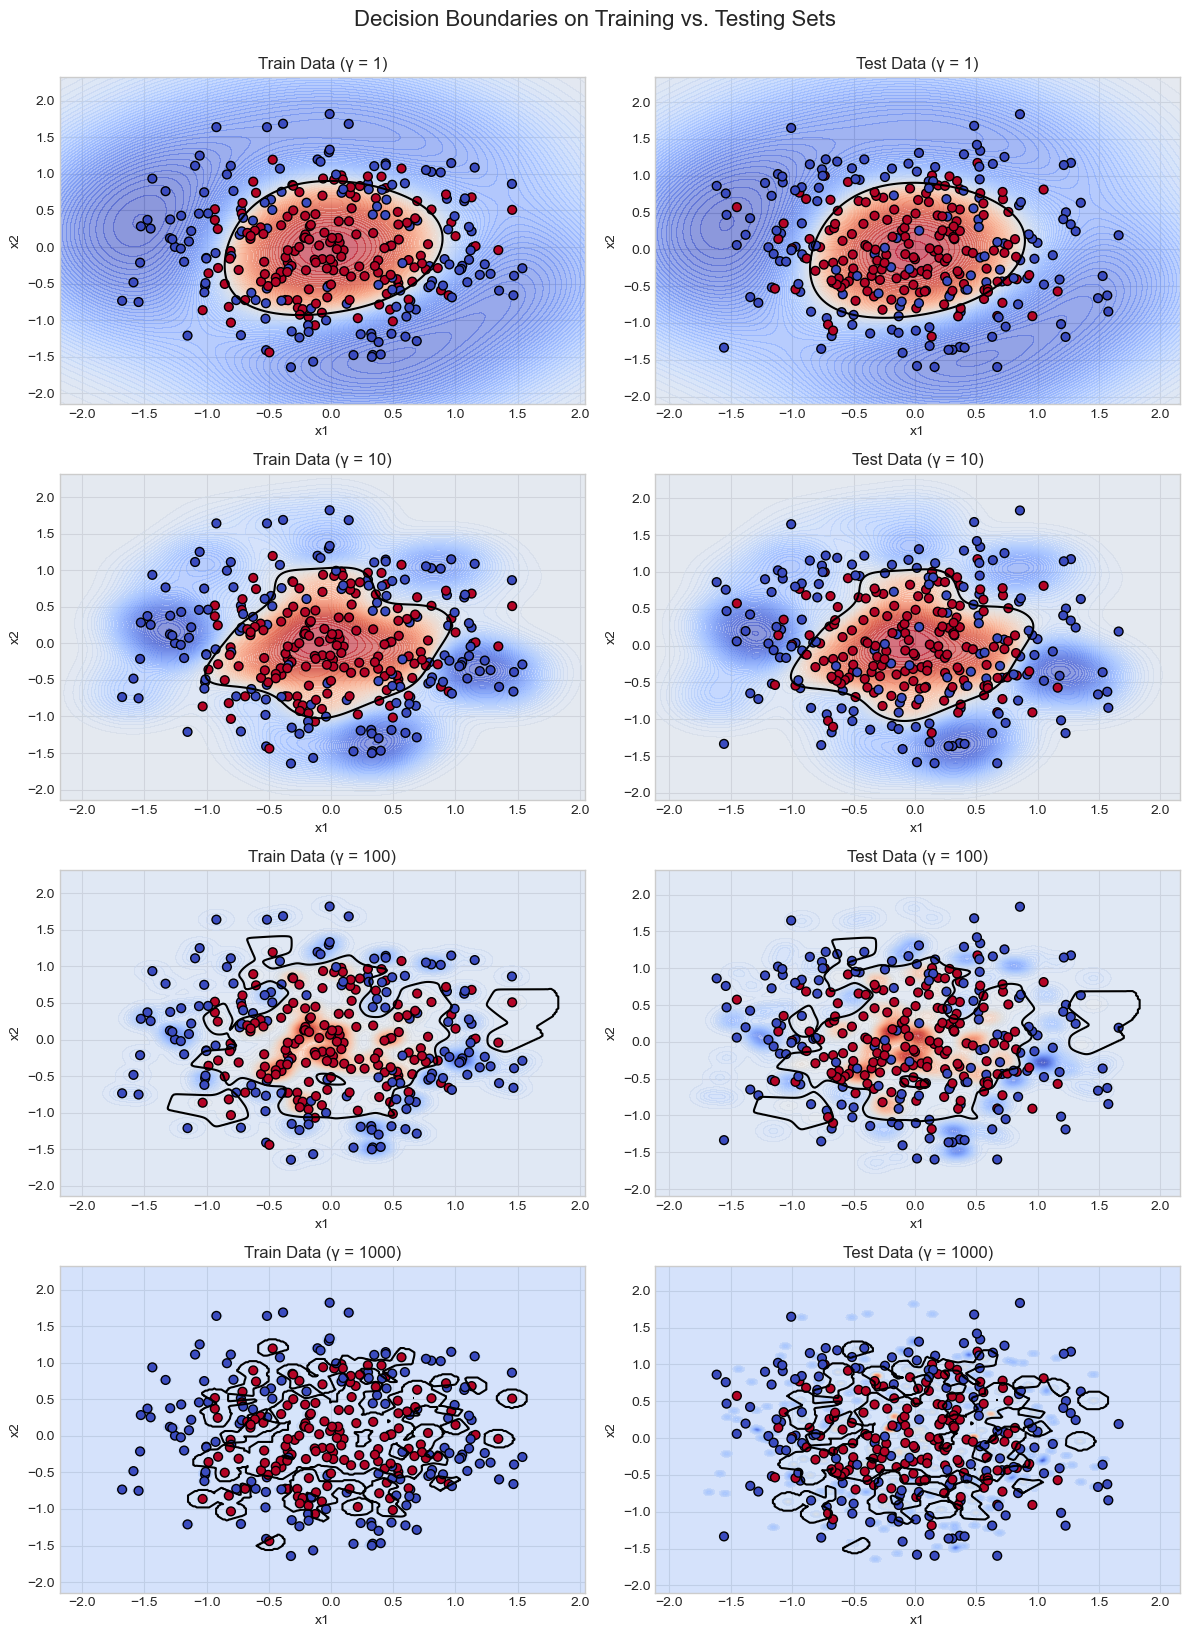

In [86]:
def plot_decision_boundary(model, X, y, ax, title):
    # Create grid
    x1 = torch.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, 300)
    x2 = torch.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, 300)
    X1, X2 = torch.meshgrid(x1, x2, indexing='ij')
    grid = torch.stack([X1.ravel(), X2.ravel()], dim=1)

    # Compute prediction probabilities
    with torch.no_grad():
        scores = model.score(grid)
        probs = torch.sigmoid(scores).reshape(X1.shape).numpy()

    # Contour and scatter plot
    ax.contourf(X1.numpy(), X2.numpy(), probs, levels=100, cmap="coolwarm", alpha=0.6)
    ax.contour(X1.numpy(), X2.numpy(), probs, levels=[0.5], colors='k', linewidths=1.5)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolor="k", s=40)
    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")


fig, axes = plt.subplots(len(gammas), 2, figsize=(12, 4 * len(gammas)))

for i, gamma in enumerate(gammas):
    model = models[gamma]

    # Plot decision boundary on training data
    plot_decision_boundary(model, X_train, y_train, axes[i, 0],
                           title=f"Train Data (γ = {gamma})")

    # Plot decision boundary on test data
    plot_decision_boundary(model, X_test, y_test, axes[i, 1],
                           title=f"Test Data (γ = {gamma})")

plt.tight_layout()
plt.suptitle("Decision Boundaries on Training vs. Testing Sets", fontsize=16, y=1.02)
plt.show()


As we can see, as the gamma values increase, the model creates much wigglier boundaries around the data points and overfits to the training data. When $\gamma = 1$, the boundary is very generalized whereas when $\gamma = 1000$, the boundary is very specific.

To verify this overfitting, the code below generates ROC (Receiver Operating Characteristic) curves to compare how different gamma values affect model performance on both the training and testing datasets. It creates a side-by-side plot with one subplot for training data and one for testing data. For each gamma value, it computes the false positive rate (FPR) and true positive rate (TPR) using the predicted probabilities, then plots the ROC curve along with the area under the curve (AUC) score in the legend. A diagonal dashed line is added as a baseline to represent random guessing.

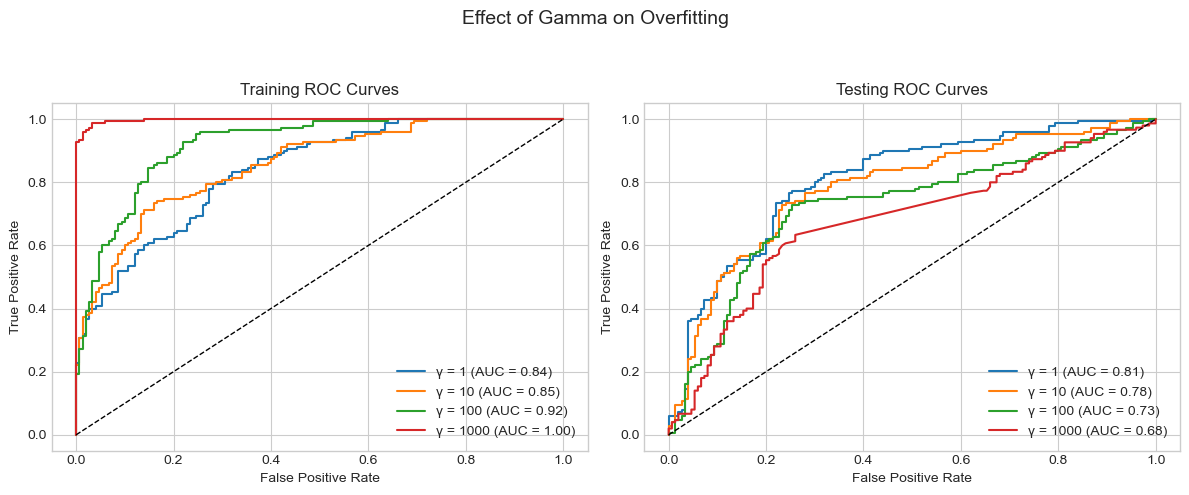

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, (X_name, y_true, probs_dict) in enumerate([
    ("Training", y_train.numpy(), probs_train),
    ("Testing", y_test.numpy(), probs_test)
]):
    ax = axes[i]
    for gamma, probs in probs_dict.items():
        fpr, tpr, _ = roc_curve(y_true, probs)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"γ = {gamma} (AUC = {roc_auc:.2f})")

    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_title(f"{X_name} ROC Curves")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend()
    ax.grid(True)

plt.suptitle("Effect of Gamma on Overfitting", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


These ROC plots clearly demonstrate how the wrong choice of gamma in a kernelized logistic regression model leads to overfitting. As $\gamma$ increases from 1 to 1000, the model's performance on the training data improves steadily, reaching a perfect AUC of 1.00 at $\gamma = 1000$, indicating that the model is memorizing the training set. However, this increase in training performance comes at the cost of generalization, as shown by the decreasing AUC values on the testing data. While $\gamma = 1$ achieves a relatively strong balance (AUC = 0.81 on test), $\gamma = 1000$ drops to a test AUC of only 0.68, clearly showing that the model performs worse on unseen data despite fitting the training set perfectly. This growing gap between training and testing performance as gamma increases demonstrates overfitting.

# Concluding Discussion

Through this project, I gained a deeper understanding of how kernelized logistic regression can model complex, nonlinear decision boundaries that linear models cannot. My findings showed that the model performed particularly well on nonlinear datasets like concentric circles, successfully capturing class boundaries using the RBF kernel. I observed that increasing $\gamma$ made the model more flexible, but beyond a certain point, it led to overfitting, where the model fit noise in the training data and performed poorly on test data. Similarly, adjusting $\lambda$ revealed the trade-off between sparsity and performance—low $\lambda$ allowed the model to closely fit the data but increased the risk of overfitting, while high $\lambda$ promoted generalization by reducing the number of non-zero weights (support vectors). Overall, this project demonstrated that kernelized logistic regression is highly effective for nonlinear classification problems, but achieving optimal performance requires careful tuning of both $\gamma$ and $\lambda$.